In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('D3.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142219 entries, 0 to 142218
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           142219 non-null  int64  
 1   Month          142219 non-null  int64  
 2   Location       142219 non-null  object 
 3   MinTemp        142219 non-null  float64
 4   MaxTemp        142219 non-null  float64
 5   Rainfall       142219 non-null  float64
 6   Evaporation    142219 non-null  float64
 7   Sunshine       142219 non-null  float64
 8   WindGustDir    142219 non-null  object 
 9   WindGustSpeed  142219 non-null  int64  
 10  WindDir9am     142219 non-null  object 
 11  WindDir3pm     142219 non-null  object 
 12  WindSpeed9am   142219 non-null  int64  
 13  WindSpeed3pm   142219 non-null  int64  
 14  Humidity9am    142219 non-null  float64
 15  Humidity3pm    142219 non-null  float64
 16  Pressure9am    142219 non-null  float64
 17  Pressure3pm    142219 non-nul

In [2]:
# This block of code will do the processing as mentioned above. The processed data may need further processing for LR and NN. 

# Drop columns that should be removed due to high correlation with other variables
columns_to_drop = ['Year', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
df2 = df.drop(columns=columns_to_drop)

# Create new averaged variables "Temp" and "Pressure" and then drop 4 columns used for creating these variables
df2['Pressure'] = (df2['Pressure9am'] + df2['Pressure3pm'])/2
df2['Temp'] = (df2['MinTemp'] + df2['MaxTemp'])/2
columns_to_drop2 = ['Pressure9am', 'Pressure3pm', 'MinTemp', 'MaxTemp']
df2 = df2.drop(columns=columns_to_drop2)

# Use one-hot encoding for categorical variables
df2 = pd.get_dummies(df2)
print(df2.info())

# Target/input split
y = df2['RainTomorrow']
X = df2.drop(['RainTomorrow'], axis=1)

# Split the data into training and testing data
from sklearn.model_selection import train_test_split

rs = 10
X_mat = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142219 entries, 0 to 142218
Columns: 109 entries, Month to WindDir3pm_WSW
dtypes: bool(97), float64(7), int64(5)
memory usage: 26.2 MB
None


In [3]:
# Normalization is need for ANN

from sklearn.preprocessing import StandardScaler
# initialise a standard scaler object
scaler = StandardScaler()
# visualise min, max, mean and standard dev of data before scaling
print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
format(i, min(col), max(col), np.mean(col), np.std(col)))
# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
X_train = scaler.fit_transform(X_train, y_train)
print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
format(i, min(col), max(col), np.mean(col), np.std(col)))
# use the statistic that you learned from training to transform test data
# NEVER learn from test data, this is supposed to be a set of dataset
# that the model has never seen before
X_test = scaler.transform(X_test)

Before scaling
-------------
Variable #4: min 7, max 135, mean 40.02 and std dev 13.15
After scaling
-------------
Variable #4: min -2.51164382853385, max 7.223836994226553, mean 0.00 and std dev 1.00


In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

model_1 = MLPClassifier(random_state=rs)
model_1.fit(X_train, y_train)

print("Train accuracy:", model_1.score(X_train, y_train))
print("Test accuracy:", model_1.score(X_test, y_test))

y_pred = model_1.predict(X_test)
print(classification_report(y_test, y_pred))

print(model_1)

C:\Users\zhong\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train accuracy: 0.9023434753347463
Test accuracy: 0.8394506164158815
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     33101
           1       0.66      0.58      0.62      9565

    accuracy                           0.84     42666
   macro avg       0.77      0.75      0.76     42666
weighted avg       0.83      0.84      0.84     42666

MLPClassifier(random_state=10)


In [10]:
print(df2.shape)

(142219, 109)


In [ ]:
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# According to the above reference, network architecture has 108 neurons in the input layer, and 100 neurons in the hidden layer
# 200 iterations, and the activation function is relu. Other default parameters are listed in the ref. 

# Q: What is the classification accuracy on training and test datasets?
# A: Training accuray is 0.9023 and testing acuuracy is 0.8395. Clearly overfitting

# Q : Did the training process converge and result in the best model?
# A: No, the covergence does not reach so a better model is needed. 

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

params = {'hidden_layer_sizes': [(10,), (15,), (20,)], 'activation': ['tanh', 'relu'], 'alpha': [0.0001, 0.001, 0.01]}

cv_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_1.fit(X_train, y_train)
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([ 60.6755306 , 147.57565768, 176.66081545,  77.2388556 ,
       129.31005886, 174.76769421,  89.20762243, 135.62039633,
       142.86365643, 102.31134944, 153.58999109, 184.87137692,
       101.38149264, 140.79991834, 170.35500779, 105.9459919 ,
       146.45986218, 129.63852873]), 'std_fit_time': array([13.82343333, 31.07740652, 27.86327362, 17.05277287, 19.88105242,
       25.51248454, 15.26257181, 18.61452822, 23.35298348, 13.99678521,
       25.46197619, 24.27432266, 17.56569081, 31.1736494 , 16.14499578,
       28.05217951, 29.60379067, 22.7999815 ]), 'mean_score_time': array([0.01906281, 0.02597799, 0.02293022, 0.02227468, 0.03389192,
       0.03788629, 0.02104986, 0.02737467, 0.03292575, 0.02284272,
       0.02886419, 0.02491679, 0.02578139, 0.02161052, 0.0369597 ,
       0.0189635 , 0.03480372, 0.02257109]), 'std_score_time': array([0.00259808, 0.00338896, 0.00154808, 0.01061439, 0.01613317,
       0.01441669, 0.00457446, 0.00528132, 0.00800946, 0.010465

In [15]:
print(cv_1.best_params_)

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (15,)}


In [16]:
print("Train accuracy:", cv_1.score(X_train, y_train))
print("Test accuracy:", cv_1.score(X_test, y_test))

Train accuracy: 0.8675178045865016
Test accuracy: 0.8577555899310927


In [ ]:
cv_1.best_estimator.fit()

In [5]:
# Perform dimension reduction using decision tree

import pickle
with open('Assign2_DT.pickle', 'rb') as f:
    dt_best,roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)

print(dt_best.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 5}


In [6]:
# inside `dm_tools.py' together with data_prep()
import numpy as np

def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

analyse_feature_importance(dt_best.best_estimator_, X.columns)

Humidity3pm : 0.6210886371783307
Rainfall : 0.1013670287873209
WindGustSpeed : 0.07786988178691295
Pressure : 0.06931905985641469
Sunshine : 0.06489778479388851
Temp : 0.017297934703712024
Humidity9am : 0.010426928406427534
WindSpeed3pm : 0.005571413233730641
Location_MountGinini : 0.0036902773321136743
WindSpeed9am : 0.002731845904030169
Evaporation : 0.0024920007843218643
WindDir3pm_NNW : 0.002172839329360932
Location_Albany : 0.002149410626922742
Location_Wollongong : 0.0020068298629072273
WindDir3pm_N : 0.0016369502393569556
WindGustDir_NE : 0.0015878863415322696
Location_Brisbane : 0.0015085686366425846
WindDir9am_NNE : 0.001215868033739137
Location_NorahHead : 0.0011290139783953137
Location_Dartmoor : 0.0010830494231520303


In [7]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(dt_best.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)

print(X_train_sel_model.shape)

(99553, 7)


In [9]:
from sklearn.model_selection import GridSearchCV

params = {'hidden_layer_sizes': [(10,), (15,), (20,)], 'alpha': [0.001, 0.0001]}

cv_sel_model = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv_sel_model.fit(X_train_sel_model, y_train)

print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))

y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(cv_sel_model.best_params_)

Train accuracy: 0.8458911333661466
Test accuracy: 0.8471616744011625
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     33101
           1       0.74      0.49      0.59      9565

    accuracy                           0.85     42666
   macro avg       0.80      0.72      0.75     42666
weighted avg       0.84      0.85      0.83     42666

{'alpha': 0.0001, 'hidden_layer_sizes': (20,)}


In [10]:
cv_sel_model.best_estimator_.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(20,), random_state=10)

In [12]:
# Number of iterations needed to train this netwrok

print(cv_sel_model.best_estimator_.n_iter_)

119


In [ ]:
# No overfitting because training and testing accuray are almost the same. 
# The bset model is the second model that Used Grid search with cross validation

In [6]:
model_2 = MLPClassifier(max_iter=700, random_state=rs)
model_2.fit(X_train, y_train)

print("Train accuracy:", model_2.score(X_train, y_train))
print("Test accuracy:", model_2.score(X_test, y_test))

y_pred = model_2.predict(X_test)
print(classification_report(y_test, y_pred))

print(model_2)

Train accuracy: 0.90437254527739
Test accuracy: 0.8381615337739652
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     33101
           1       0.66      0.59      0.62      9565

    accuracy                           0.84     42666
   macro avg       0.77      0.75      0.76     42666
weighted avg       0.83      0.84      0.83     42666

MLPClassifier(max_iter=700, random_state=10)


In [7]:
# Does not help with iterations of 700 for the testing accuracy, but it did converge

In [8]:
print(X_train.shape)

(99553, 108)


In [10]:
from sklearn.model_selection import GridSearchCV

params = {'hidden_layer_sizes': [(x,) for x in range(5, 86, 20)]}

cv_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_1.fit(X_train, y_train)
result_set = cv_1.cv_results_
print(result_set)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(5,), (25,), (45,), (65,),
                                                (85,)]},
             return_train_score=True)

Total number of models:  5


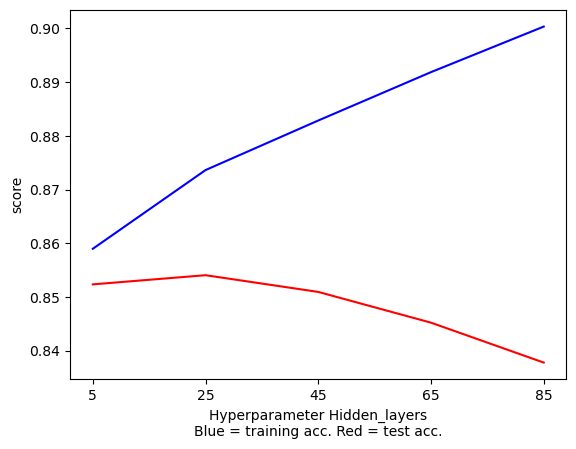

In [12]:
print(cv_1.best_params_)

Total number of models:  5


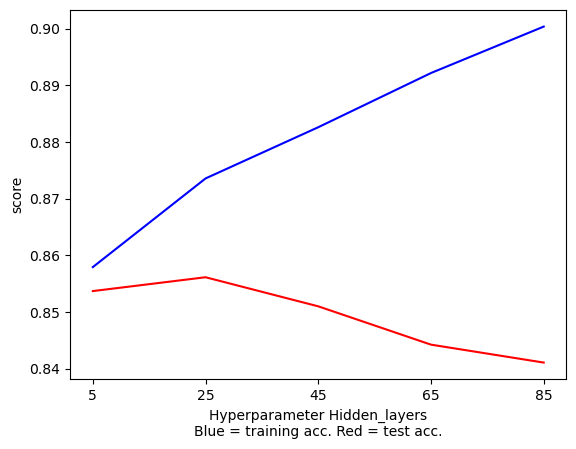

In [13]:
### Enter your code
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(5, 86, 20))
plt.ylabel('score')
plt.show()

In [14]:
print("Train accuracy:", cv_1.score(X_train, y_train))
print("Test accuracy:", cv_1.score(X_test, y_test))

y_pred = cv_1.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv_1.best_params_)

Train accuracy: 0.8729721856699446
Test accuracy: 0.8573571462054095
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     33101
           1       0.74      0.56      0.64      9565

    accuracy                           0.86     42666
   macro avg       0.81      0.75      0.78     42666
weighted avg       0.85      0.86      0.85     42666

{'hidden_layer_sizes': (25,)}


In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

params = {'hidden_layer_sizes': [(15,), (25,), (35,)]}

cv_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_1.fit(X_train, y_train)
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([ 85.81845374, 173.21200633, 208.3422066 ]), 'std_fit_time': array([24.70815484, 23.85140754, 34.30248311]), 'mean_score_time': array([0.02101002, 0.02545979, 0.02534158]), 'std_score_time': array([0.01009936, 0.00937063, 0.01180751]), 'param_hidden_layer_sizes': masked_array(data=[(15,), (25,), (35,)],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'hidden_layer_sizes': (15,)}, {'hidden_layer_sizes': (25,)}, {'hidden_layer_sizes': (35,)}], 'split0_test_score': array([0.85787465, 0.85405785, 0.85275211]), 'split1_test_score': array([0.85636802, 0.85707111, 0.85616714]), 'split2_test_score': array([0.85365609, 0.85526316, 0.84803134]), 'split3_test_score': array([0.85886489, 0.85544952, 0.85464591]), 'split4_test_score': array([0.85765947, 0.85966851, 0.85585133]), 'split5_test_score': array([0.85273732, 0.85464591, 0.85253641]), 'split6_test_score': array([0.8615771 , 0.85735811, 0.85896534]), 'split7_test_

In [15]:
# Have a finer search between 5 and 45 neurons!

In [12]:
result_set = cv_1.cv_results_

import matplotlib.pyplot as plt
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
print(train_result, test_result)
# plot hidden layers hyperparameter values vs training and test accuracy score
# plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
# plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
# plt.xticks(range(0, 35, 5))
# plt.ylabel('score')
# plt.show()

Total number of models:  3
[0.86843747 0.8735693  0.87821674] [0.85723186 0.85613695 0.85328421]


In [13]:
# 15 has slightly better results than 25. In the grid search we will use (10, 15, 20) for number of neurons in the hidden layer 